## SpTransformer Predictions

In [ ]:
import pandas as pd
import numpy as np
import tqdm
import os
import torch

# Don't use GPU in the notebook
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Import what we need from /home/elek/projects/SpliceTransformer
import sys
sys.path.append('/home/elek/projects/SpliceTransformer')
from tasks_annotate_mutations import SpTransformerDriver


Test that SpTransformer prediction works for a mock DNA sequence.

In [ ]:
# Test the model with a mock sequence
input_seq = 'N'*4500 + 'ACGTAGGGCG' + 'N'*4500

# Encode and predict using the SpTransformerDriver default model
model = SpTransformerDriver(ref_fasta='', load_db=False, context=4500)
input_encoded = model.one_hot_encode(input_seq)
output = model.calc_single_sequence(input_encoded, encode=False)

print(f"Input sequence length: {len(input_seq)}")
print(f"Output shape: {output.shape}")
print(f"Splice scores shape: {output[:, :3].shape}")
print(f"Tissue usage shape: {output[:, 3:].shape}")

torch device:cpu
Input sequence length: 9010
Output shape: (10, 18)
Splice scores shape: (10, 3)
Tissue usage shape: (10, 15)


By default, SpTransformer predicts values for 15 GTEx tissues. I am only interested in Brain and Heart for now, because I can compare them to SplicEvo predictions.

In [3]:
tis_dic = {0: 'Adipose Tissue', 1: 'Blood', 2: 'Blood Vessel', 3: 'Brain', 4: 'Colon', 5: 'Heart', 6: 'Kidney',
                7: 'Liver', 8: 'Lung', 9: 'Muscle', 10: 'Nerve', 11: 'Small Intestine', 12: 'Skin', 13: 'Spleen', 14: 'Stomach'}
tis_target = [3, 5]

Load test data used for SplicEvo.

In [4]:
# Load test data
test_path = "/home/elek/projects/splicing/results/data_processing_subset/processed_data_test.npz"
data = np.load(test_path)

test_sequences = data['sequences']
test_labels = data['labels']

test_sse = data['usage_sse']
test_alpha = data['usage_alpha']
test_beta = data['usage_beta']

test_sse = np.nan_to_num(test_sse, nan=0.0)
test_alpha = np.nan_to_num(test_alpha, nan=0.0)
test_beta = np.nan_to_num(test_beta, nan=0.0)

print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test usage shape: {test_sse.shape}")
print(f"Test alpha shape: {test_alpha.shape}")
print(f"Test beta shape: {test_beta.shape}")

Test sequences shape: (58097, 10000, 4)
Test labels shape: (58097, 1000)
Test usage shape: (58097, 1000, 4)
Test alpha shape: (58097, 1000, 4)
Test beta shape: (58097, 1000, 4)


In [35]:
# Splice sites in the first few test sequences
for i in range(3):
    print(f"Splice sites in sequence {i}:")
    print(f"  donors (1)    {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  acceptors (2) {np.where(test_labels[i] == 2)[0].tolist()}")

Splice sites in sequence 0:
  donors (1)    []
  acceptors (2) [0]
Splice sites in sequence 1:
  donors (1)    [0, 788]
  acceptors (2) []
Splice sites in sequence 2:
  donors (1)    [168, 759]
  acceptors (2) [555]


Inspect distribution of usage values at splice sites

In [ ]:
cls_dict = {0: 'non-splice site', 1: 'donor', 2: 'acceptor'}

for cls in [1, 2]: # 1: donor, 2: acceptor
    cls_idxs = np.where(test_labels == cls)[0]
    print(f"Number of {cls_dict[cls]} sites: {len(cls_idxs)}")
    for tis_idx in tis_target:
        tis = tis_dic[tis_idx]
        sse_values = test_sse[cls_idxs, tis_idx]
        alpha_values = test_alpha[cls_idxs, tis_idx]
        beta_values = test_beta[cls_idxs, tis_idx]
        print(f"{tis}")
        print(f"{np.sum(sse_values > 0)} sites have mapped usage values ({np.sum(sse_values > 0) / len(sse_values) * 100:.2f}%)")
        print(f"    SSE - mean: {np.mean(sse_values):.4f}, std: {np.std(sse_values):.4f}")
        print(f"    Alpha - mean: {np.mean(alpha_values):.4f}, std: {np.std(alpha_values):.4f}")
        print(f"    Beta - mean: {np.mean(beta_values):.4f}, std: {np.std(beta_values):.4f}")

Number of donor sites: 64752
Brain
156 sites have mapped usage values (0.24%)
    SSE - mean: 0.0005, std: 0.0207
    Alpha - mean: 0.0304, std: 3.1174
    Beta - mean: 0.0128, std: 1.5466
Heart
175 sites have mapped usage values (0.27%)
    SSE - mean: 0.0005, std: 0.0209
    Alpha - mean: 0.0278, std: 2.4794
    Beta - mean: 0.0111, std: 1.1376
Number of acceptor sites: 61732
Brain
173 sites have mapped usage values (0.28%)
    SSE - mean: 0.0005, std: 0.0218
    Alpha - mean: 0.0277, std: 2.4897
    Beta - mean: 0.0167, std: 1.6032
Heart
144 sites have mapped usage values (0.23%)
    SSE - mean: 0.0004, std: 0.0194
    Alpha - mean: 0.0221, std: 2.1621
    Beta - mean: 0.0168, std: 1.7340


Check that SpTransformer prediction works for batch of sequences.

In [ ]:
output = model.calc_batched_sequence(test_sequences[0:10], encode=False)
splice_probs = output[:,:,:3]
splice_preds = np.argmax(splice_probs, axis=-1)
usage_preds = output[:,:,3:]

print(f"Output shape: {output.shape}")
print(f"Splice scores shape: {splice_probs.shape}")
print(f"Tissue usage shape: {usage_preds.shape}")

Output shape: (10, 1000, 18)
Splice scores shape: (10, 1000, 3)
Tissue usage shape: (10, 1000, 15)


Use SpliceTransformer for predictions on test data I used for SplicEvo.

```bash
conda activate sptransformer
python /home/elek/projects/splicing/scripts/predict.py \
--input /home/elek/projects/splicing/results/data_processing/processed_data_test.npz \
--output /home/elek/projects/splicing/results/sptransformer/test_predictions.npz \
--weights /home/elek/projects/SpliceTransformer/model/weights/SpTransformer_pytorch.ckpt
```

Load resulting predictions.

In [ ]:
import numpy as np

# Load the model predictions from a file
pred_path = "/home/elek/projects/SpliceTransformer/test_predictions.npz"
pred = np.load(pred_path)

# Keys in the loaded data
print(f"Available keys: {list(pred.keys())}")
for key in pred.keys():
    print(f"{key}: {pred[key].shape}")


Available keys: ['splice_preds', 'splice_probs', 'splice_usage', 'labels_true', 'usage_true']
splice_preds: (58097, 1000)
splice_probs: (58097, 1000, 3)
splice_usage: (58097, 1000, 15)
labels_true: (58097, 1000)
usage_true: (58097, 1000, 4)


SpTransformer works with the following predictions:  
0 - non-splice site, 1 - acceptor, 2 - donor.  

To calculate accuracy against true labels, I need to match outputs to what SplicEvo reports:  
0 - non-splice site, 1 - donor, 2 - acceptor

In [41]:
# reorder columns of probabilities matrices
pred_probs = pred['splice_probs'][:,:, [0,2,1]]
# replace class values: 1 with 2 and 2 with 1
pred_preds = pred['splice_preds']
pred_preds[pred_preds == 1] = 3
pred_preds[pred_preds == 2] = 1
pred_preds[pred_preds == 3] = 2

Inspect a few sequences and their predicted splice sites.

In [ ]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_preds[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(test_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_preds[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       []
  predicted    []
(2) Acceptor splice sites in sequence 0:
  actual    [0]
  predicted []

(1) Donor splice sites in sequence 1:
  actual       [0, 788]
  predicted    [786]
(2) Acceptor splice sites in sequence 1:
  actual    []
  predicted []

(1) Donor splice sites in sequence 2:
  actual       [168, 759]
  predicted    [757]
(2) Acceptor splice sites in sequence 2:
  actual    [555]
  predicted [555]

(1) Donor splice sites in sequence 3:
  actual       [162]
  predicted    [652]
(2) Acceptor splice sites in sequence 3:
  actual    [20]
  predicted [20, 559]


In [48]:
for i, j in [(0, 0), (1, 0), (2, 168), (2, 759)]:
    print(f"Sequence {i}, position {j}:\n  true label: {test_labels[i,j]}\n  pred label: {pred_preds[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 2
  pred label: 0
  porbs:[9.9994123e-01 1.3466172e-05 4.5331246e-05]
Sequence 1, position 0:
  true label: 1
  pred label: 0
  porbs:[9.999993e-01 4.628972e-07 2.009506e-07]
Sequence 2, position 168:
  true label: 1
  pred label: 0
  porbs:[9.9999988e-01 9.8917766e-08 3.9064183e-08]
Sequence 2, position 759:
  true label: 1
  pred label: 0
  porbs:[9.9999785e-01 1.8221517e-06 3.8113342e-07]


Calculate PR-AUC, the area under the precision-recall curve.

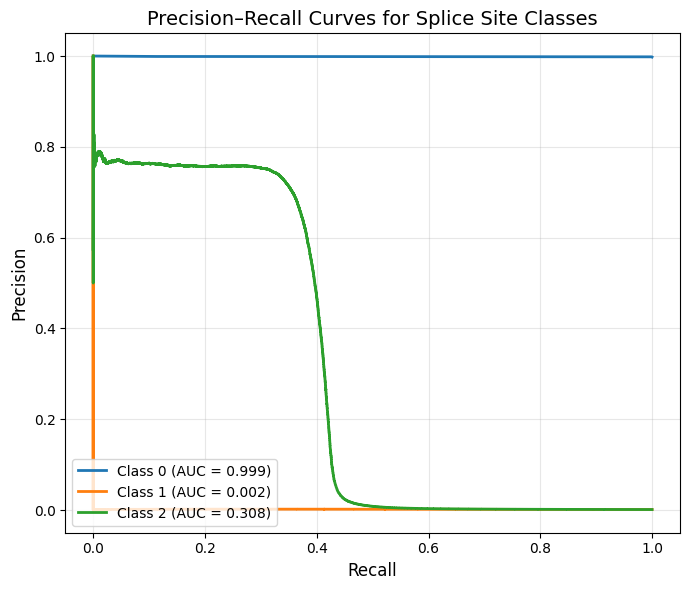

PR-AUC for class 0: 0.9988
PR-AUC for class 1: 0.0016
PR-AUC for class 2: 0.3075


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(7, 6))

for class_idx in range(3):
    # Binary labels for the current class
    y_true = (data['labels'] == class_idx).astype(int).reshape(-1)
    # Predicted probabilities for that class
    y_scores = pred_probs[:, :, class_idx].reshape(-1)

    # Compute PR curve and area
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    # Plot
    plt.plot(
        recall, precision,
        label=f"Class {class_idx} (AUC = {pr_auc:.3f})",
        linewidth=2
    )

# Plot formatting
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print PR-AUC values
for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for class {c}: {auc_score:.4f}")


Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [12]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    y_true = (data['labels'] == class_idx).astype(int)
    y_true = y_true.reshape(-1)
    y_scores = pred_probs[:,:,class_idx]
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.9983
Top-k accuracy for class 1: 0.0011
Top-k accuracy for class 2: 0.4056
